## Task 1

In task 1, the test dataset (to be predicted) includes users ID 80,000 to 100,000 only. To better understand the trajectories of these users, let's compare them with previous trajectories.

<img src="https://connection.mit.edu/sites/default/files/images/tasks.png" alt="Alt Text" width="500" height="200" />

In [1]:
# Libraries
import os, glob, datetime, tqdm, warnings
import pandas as pd

# Mobility
import skmob
from skmob.models.markov_diary_generator import MarkovDiaryGenerator
from skmob.models.epr import Ditras

# Geospatial (for the tessellation)
import geopandas as gpd
from shapely.geometry import Polygon

warnings.filterwarnings('ignore')

In [3]:
# Load dataset 
task1 = pd.read_csv('/data_1/mobility/task1_dataset.csv')

# Split train/test
task1_train = task1[task1['x'] != 999] # Days 0-59
task1_test = task1[task1['x'] == 999] # Days 60-74

# Copy data (for clean data handling)
data = task1_train

# Combine 'd' and 't' columns to create a single timestamp column
data['datetime'] = pd.to_datetime(data['d'] * 24 * 60 * 60 + data['t'] * 30 * 60, unit='s')

# Add "cluster ID" as a string to feed into skmob function
data['cluster_id'] = [str(x) + '_' + str(y) for x, y in zip(data['x'], data['y'])]

/tmp/ipykernel_3149246/2750557767.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['datetime'] = pd.to_datetime(data['d'] * 24 * 60 * 60 + data['t'] * 30 * 60, unit='s')
/tmp/ipykernel_3149246/2750557767.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster_id'] = [str(x) + '_' + str(y) for x, y in zip(data['x'], data['y'])]


In [4]:
# Create a TrajDataFrame
traj_df = skmob.TrajDataFrame(data[['uid','cluster_id','datetime']], datetime='datetime', user_id='user')

#### Scikit-mobility: MarkovDiaryGenerator 

In [5]:
# Create a Markov Diary for each user
def create_mdg(user_id=None, n_days=15, n_hours=24, seed=42):
    
    # Initiate 
    mdg = MarkovDiaryGenerator()
    
    # Create MDG for a single user
    mdg.fit(traj_df[traj_df.uid == user_id], 1, lid='cluster_id');

    start_time = pd.to_datetime('1970/02/21 07:00:00')
    diary = mdg.generate(n_days*n_hours, start_time, seed)
    # print(diary)
    
    return diary

In [69]:
%%capture --no-stdout --no-display 

mdg_full = []

# Loop through all users
for user_id in tqdm.tqdm(range(80000, 80003)):
    mdg = create_mdg(user_id=user_id)
    instance = {'uid': user_id, 
                'datetime': mdg['datetime'],
                'abstract_location': mdg['abstract_location']}
    mdg_full.append(instance)

mdg_full_dict = {item['uid']: (item['datetime'], item['abstract_location']) for item in mdg_full}

#### Viz

<Axes: xlabel='abstract_location', ylabel='Count'>

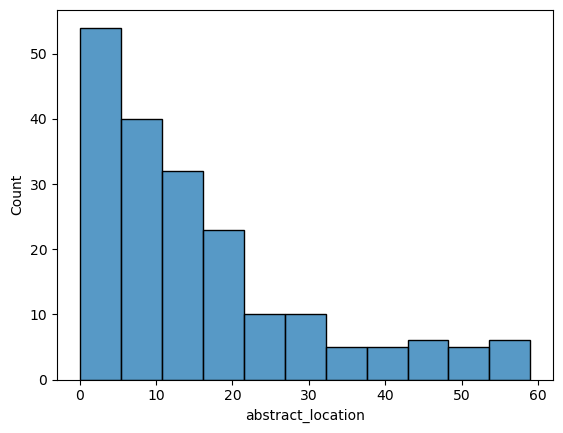

In [87]:
import seaborn as sns
sns.histplot(mdg_full[0]['abstract_location']) # UserID 80000

#### DITRAS
The DITRAS (DIary-based TRAjectory Simulator) modelling framework to simulate the spatio-temporal patterns of human mobility [PS2018]. DITRAS consists of two phases:

**1) Mobility Diary Generation:** DITRAS generates a mobility diary which captures the temporal patterns of human mobility.
**2) Trajectory Generation:** DITRAS transforms the mobility diary into a mobility trajectory which captures the spatial patterns of human movements.

Outline of the DITRAS framework. DITRAS combines two probabilistic models: a diary generator (e.g., $MD(t)$) and trajectory generator (e.g., *d-EPR*). The diary generator produces a mobility diary $D$. The mobility diary $D$ is the input of the trajectory generator together with a weighted spatial tessellation of the territory $L$ . From $D$ and $L$ the trajectory generator produces a synthetic mobility trajectory $S$.

- **rho** (float, optional) – corresponds to the parameter $\rho$ ranges from [0,1] and is in the Action selection mechanism of the DensityEPR model and controls the agent’s tendency to explore a new location during the next move versus returning to a previously visited location. (The default value is  ρ = 0.6).
- **gamma** (float, optional) – corresponds to the parameter $\gamma$ where $\gamma \geq 0$ and is in the Action selection mechanism of the DensityEPR model controls the agent’s tendency to explore a new location during the next move versus returning to a previously visited location. (The default value is  γ = 0.21).

In [7]:
## Example of tesssellation data
# url = skmob.utils.constants.NY_COUNTIES_2011
# tessellation_example = gpd.read_file(url)
# tessellation_example.plot()

### Create a synthetic tessellation for our 200 by 200 grid

# Define the study area bounding box
xmin, ymin, xmax, ymax = (0, 0, 100000, 100000)

# Define the cell size (resolution) in meters
cell_size = 500

# Create a list of polygons representing the grid cells
polygons = []
for x in range(int(xmin), int(xmax), cell_size):
    for y in range(int(ymin), int(ymax), cell_size):
        # Create a square polygon for each cell
        polygons.append(Polygon([(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)]))

# Create a GeoDataFrame from the polygons
tessellation_gdf = gpd.GeoDataFrame({'geometry': polygons})

# Set the CRS (e.g., EPSG:4326 for WGS84)
tessellation_gdf.crs = 'EPSG:4326'

# Save (if needed)
# tessellation_gdf.to_file('tessellation.shp')

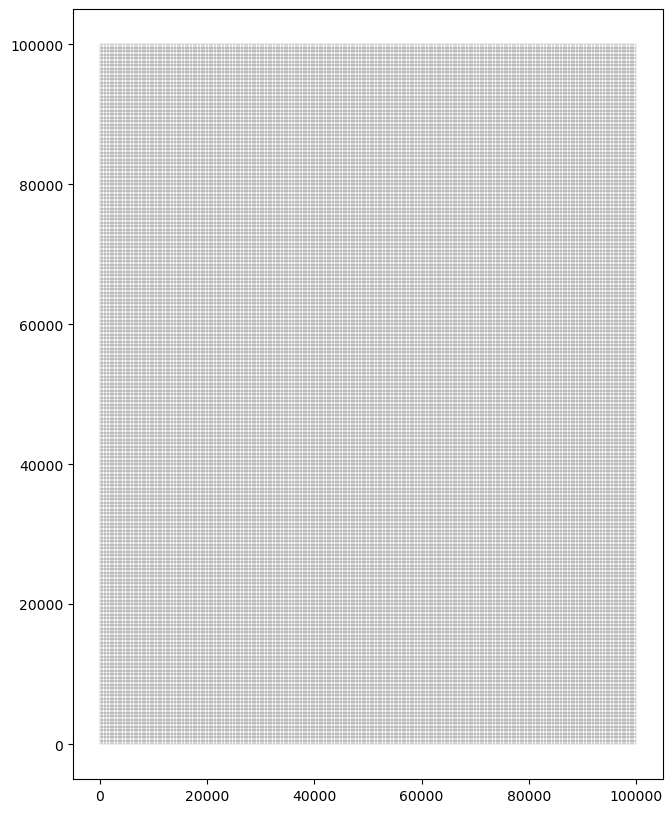

In [13]:
# Visualize tessellation
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(10,10))

tessellation_gdf.plot(ax=ax, facecolor='none', linewidth=0.1)
plt.show()

In [99]:
# Instantiate the model
ditras = Ditras(mdg, rho=0.3, gamma=0.21)

# Set parameters
tessellation = tessellation_gdf
start_time = pd.to_datetime('1970/02/21 07:00:00')
end_time = pd.to_datetime('1970/02/23 07:00:00')


# run the model
ditras_tdf = ditras.generate(start_time, end_time, tessellation, 
                n_agents=3, od_matrix=None, show_progress=True)
print(ditras_tdf.head())

KeyError: 'relevance'

#### Viz

In [12]:
mdg

datetime  abstract_location
0   1970-02-21 07:00:00                  0
1   1970-02-21 10:00:00                  1
2   1970-02-21 11:00:00                  2
3   1970-02-21 16:00:00                  3
4   1970-02-21 17:00:00                  4
..                  ...                ...
191 1970-03-07 20:00:00                 30
192 1970-03-07 21:00:00                 31
193 1970-03-07 23:00:00                 32
194 1970-03-08 02:00:00                 33
195 1970-03-08 03:00:00                 34

[196 rows x 2 columns]